### **First Step**

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.models import Model

import datetime

In [2]:
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [3]:
ds = tfds.load('mnist', split='train')
ds.as_numpy_iterator().next().keys()
# ds.as_numpy_iterator().next()['image']

dict_keys(['image', 'label'])

In [4]:
dataiterator = ds.as_numpy_iterator()
dataiterator.next()['image'].shape

(28, 28, 1)

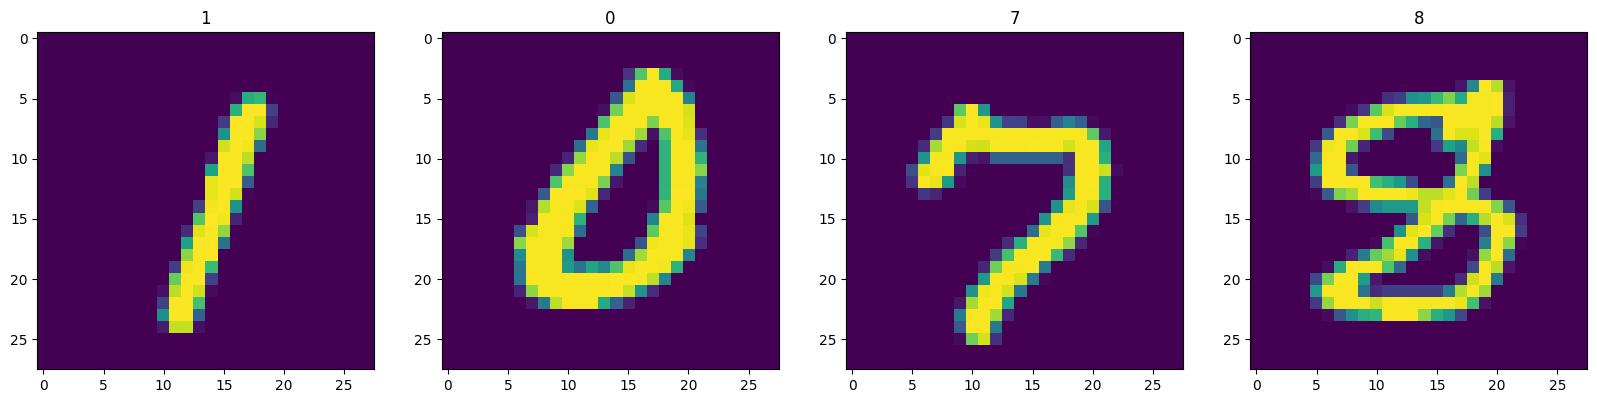

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    batch = dataiterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [6]:
def scale_images(data):
    image = data['image']
    return image/255

In [7]:
ds = tfds.load('mnist', split='train')
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

### **Build Neural Network**

#### **Build Generator**

In [8]:
def build_generator():
    model = tf.keras.models.Sequential()

    # model.add(tf.keras.layers.Input(shape=(128,)))
    # Takes in random values and reshapes it to 7x7x128
    model.add(tf.keras.layers.Dense(7*7*128, input_dim=128))
    model.add(tf.keras.layers.LeakyReLU(.2))
    model.add(tf.keras.layers.Reshape((7, 7, 128)))

    # Upsampling block 1
    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(128, 5, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(.2))

    # Upsampling block 2
    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(128, 5, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(.2))

    #Convolutional block 1
    model.add(tf.keras.layers.Conv2D(128, 4, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(.2))

    #Convolutional block 2
    model.add(tf.keras.layers.Conv2D(128, 4, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(.2))

    #Conv layer to get to one channel
    model.add(tf.keras.layers.Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 5s 5s/step


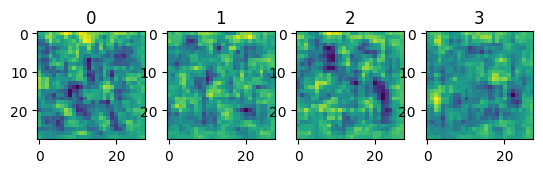

In [9]:
img = generator.predict(np.random.randn(4, 128, 1))

fig, ax = plt.subplots(ncols=4)
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

#### **Build Descriminator**

In [10]:
def build_discriminator():
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(32, 5, input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.LeakyReLU(.2))
    model.add(tf.keras.layers.Dropout(.4))

    model.add(tf.keras.layers.Conv2D(64, 5))
    model.add(tf.keras.layers.LeakyReLU(.2))
    model.add(tf.keras.layers.Dropout(.4))

    model.add(tf.keras.layers.Conv2D(128, 5))
    model.add(tf.keras.layers.LeakyReLU(.2))
    model.add(tf.keras.layers.Dropout(.4))

    model.add(tf.keras.layers.Conv2D(256, 5))
    model.add(tf.keras.layers.LeakyReLU(.2))
    model.add(tf.keras.layers.Dropout(.4))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(.4))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

### **Construct Training Loop**

#### **Setup Losses and Optimizers**

In [11]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

In [12]:
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

#### **Build Subclassed Model**

In [13]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)


        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss


    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)



        # Training the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the data of real & fake to the discriminator model
            yhat_real = self.discriminator(real_images, training = True)
            yhat_fake = self.discriminator(fake_images, training = True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create their labels
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BinaryCross
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nnLearn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

            # Create the predicted value
            predicted_labels = self.discriminator(gen_images, training=False)

            #Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        #Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"dloss":total_d_loss, "gloss":total_g_loss}
    
fashgan = FashionGAN(generator, discriminator)
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

#### **Build Callback**

In [14]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            # img.save(os.path.join('GANimages', f'generated_img_{epoch}_{i}.png'))
            img.save(os.path.join('GANimages1', f'generated_img_{epoch}_{i}.png'))

#### **Train**

In [15]:
def train_mode(mode, model, epoch, callback=[]):
    device = f'/{mode}:0'
    with tf.device(device):
        hist = model.fit(ds, epochs=epoch, callbacks=callback)
    return hist

In [16]:
CURRENT_TIME = datetime.datetime.now().strftime("%d%m%Y_%H%M%S")

try:    
    # Create folder
    os.makedirs("./model_checkpoint", exist_ok=True)
    os.makedirs("./GANimages", exist_ok=True)

    # Train model
    history = train_mode(mode='GPU', model=fashgan, epoch=2000, callback=[ModelMonitor()])



    #Save model
    generator.save(f"./model_checkpoint/generator_{CURRENT_TIME}.h5")
    discriminator.save(f"./model_checkpoint/discriminator_{CURRENT_TIME}.h5")

except Exception as e:

    print(f"\nWarning: You have a problem with error {e}")
    
    #Save model
    generator.save(f"./model_checkpoint/generator_{CURRENT_TIME}.h5")
    discriminator.save(f"./model_checkpoint/discriminator_{CURRENT_TIME}.h5")
    
except KeyboardInterrupt:

    print(f"\nYou have stopped training the model.")

    #Save model
    generator.save(f"./model_checkpoint/generator_{CURRENT_TIME}.h5")
    discriminator.save(f"./model_checkpoint/discriminator_{CURRENT_TIME}.h5")

Epoch 1/2000
249/469 [==============>...............] - ETA: 36s - dloss: 0.5095 - gloss: 0.7112
You have stopped training the model.


### **Load Model**

In [9]:
generator_dir_model = "generator_20112024_224006.h5"
# discriminator_dir_model = "discriminator_20112024_224006.h5"

generator.load_weights(os.path.join('model_checkpoint', generator_dir_model))
# discriminator.load_weights(os.path.join('model_checkpoint', discriminator_dir_model))